In [1]:
import numpy as np
import skimage
from PIL import Image
from skimage.measure import block_reduce
from skimage.color import colorconv
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from IPython.display import clear_output, display_html
from time import sleep

%matplotlib inline

In [2]:
def load_maze(path, cell_size):
    maze = skimage.io.imread(path, as_gray=True)
    maze = block_reduce(maze, cell_size, np.max)
    start = tuple(np.argwhere(maze*255==64)[0])
    finish = tuple(np.argwhere(maze*255==128)[0])
    maze[start] = 1.0
    maze[finish] = 1.0
    return maze, start, finish

In [3]:
def coordinate_to_number(coordinate, n_cols):
    return coordinate[0]*n_cols+coordinate[1]

In [4]:
class Agent:
    
    def __init__(self, maze_path, maze_cell_size):
        self.maze, self.start, self.finish = load_maze(maze_path, maze_cell_size)
        self.actionSpace = np.array([
            0, #move up
            1, #move down
            2, #move right
            3  #move left
        ])
        self.q_table = np.zeros((self.maze.size, self.actionSpace.size))
        
    def learn(self, lr=0.1, epochs=100, steps_per_epoch=300, epsilon=0.1):
        epsilon_decay = epsilon/epochs
        
        for i in range(epochs):
            self._reset()
            done = False
            
            for j in range(steps_per_epoch):
                
                self.render(i+1, j+1)
                actions = self.actionSpace
                
                # Get valid actions that actor can perform from current position
                if self.maze[self.pos] == 1.0:
                    upper_cell = (self.pos[0] - 1, self.pos[1])
                    lower_cell = (self.pos[0] + 1, self.pos[1])
                    right_cell = (self.pos[0], self.pos[1] + 1)
                    left_cell = (self.pos[0], self.pos[1] - 1)
                    
                    if self.maze[upper_cell] == 0.0:
                        actions = np.delete(actions, np.argwhere(actions == self.actionSpace[0]))
                    if self.maze[lower_cell] == 0.0:
                        actions = np.delete(actions, np.argwhere(actions == self.actionSpace[1]))
                    if self.maze[right_cell] == 0.0:
                        actions = np.delete(actions, np.argwhere(actions == self.actionSpace[2]))
                    if self.maze[left_cell] == 0.0:
                        actions = np.delete(actions, np.argwhere(actions == self.actionSpace[3]))
                        
                # Select action to perform
                if np.random.uniform() < epsilon:
                    action = np.random.choice(actions)
                else:
                    state_n = coordinate_to_number(self.pos, self.maze.shape[1])
                    action = actions[np.argmax(np.take(self.q_table[state_n], actions))]
                
                
                
                
                if self._step(action, lr):
                    clear_output(wait=True)
                    break
                clear_output(wait=True)
            epsilon -= epsilon_decay*2
        
    def _reset(self):
        self.pos = self.start
        self.pos_prev = None
        
    def _step(self, action, lr):
        gamma = 0.7
        
        reward = 1
        penalty = -10
        
        
        if action == 0:
            new_pos = (self.pos[0]-1, self.pos[1])
        if action == 1:
            new_pos = (self.pos[0]+1, self.pos[1])
        if action == 2:
            new_pos = (self.pos[0], self.pos[1]+1)
        if action == 3:
            new_pos = (self.pos[0], self.pos[1]-1)
        
        state_curr = coordinate_to_number(self.pos, self.maze.shape[1])
        state_new = coordinate_to_number(new_pos, self.maze.shape[1])
        
        if new_pos == self.pos_prev:
            self.q_table[(state_curr, action)] = (1-lr) * self.q_table[(state_curr, action)] + \
                                                 lr * (penalty + gamma * np.max(self.q_table[state_new]))
        else:
            self.q_table[(state_curr, action)] = (1-lr) * self.q_table[(state_curr, action)] + \
                                                 lr * (reward + gamma * np.max(self.q_table[state_new]))
            
        self.pos_prev = self.pos
        self.pos = new_pos
        done = self.pos == self.finish
        
        return done
        
    def qtable_to_pandas(self):
        df = pd.DataFrame({
            'up': self.q_table[:, 0],
            'down': self.q_table[:, 1],
            'right': self.q_table[:, 2],
            'left': self.q_table[:, 3],
        })
        df.index.name = 'state'
        return df
    
    def render(self, epoch_n, step_n):
        maze = self.maze.copy()
        maze[self.pos] = 0.2
        plt.figure(figsize=(8,8))
        plt.imshow(maze, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        display_html("""<html>
            <p><b>Epoch:</b> {}</p>
            <p><b>Step:</b> {}</p>
            <p><b>Position:</b> {}</p>
        </html>""".format(epoch_n, step_n, self.pos), raw=True)
        
        

# Maze #1. Size 8x8
<img src="mazes/maze1.png">

In [5]:
agent = Agent('mazes/maze1.png', (32, 32))

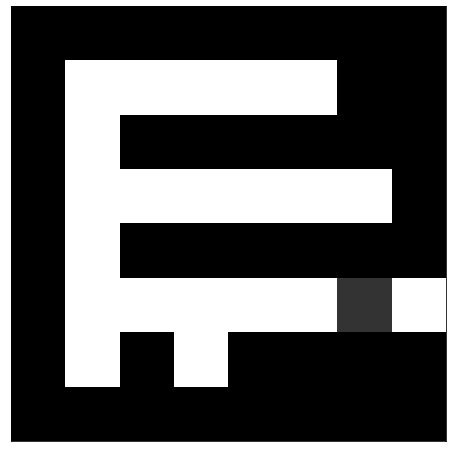

Epoch: 100 
 Step: 10 
 Position: (5, 6)

In [6]:
agent.learn()

In [7]:
qtable1 = agent.qtable_to_pandas()

In [8]:
qtable1[(qtable1.up != 0) | (qtable1.down != 0) | (qtable1.right != 0) | (qtable1.left != 0)]

,up,down,right,left
state,,,,
9,0.000000,3.048397,-1.531033,0.000000
10,0.000000,0.000000,-1.641033,-1.534465
11,0.000000,0.000000,-1.641033,-1.641997
12,0.000000,0.000000,-1.819000,-2.631997
13,0.000000,0.000000,0.000000,-2.704330
17,-1.842578,3.045460,0.000000,0.000000
25,-1.851796,3.018810,-1.531033,0.000000
26,0.000000,0.000000,-1.641033,-1.611776
27,0.000000,0.000000,-1.641033,-1.641997


# Maze #2. Size 10x10
<img src="mazes/maze2.png">

In [9]:
agent = Agent("mazes/maze2.png", (32,32))

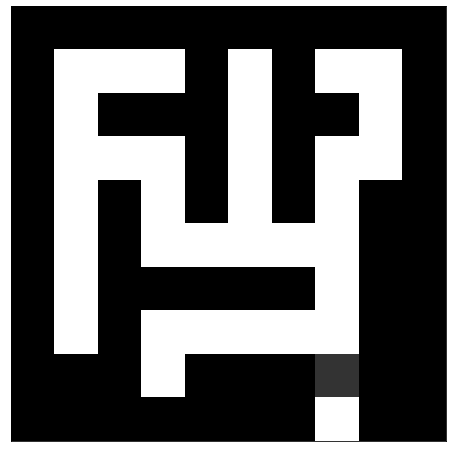

Epoch: 200 
 Step: 16 
 Position: (8, 7)

In [10]:
agent.learn(epochs=200, epsilon=0.2)

In [11]:
qtable2 = agent.qtable_to_pandas()

In [12]:
qtable2[(qtable2.up != 0) | (qtable2.down != 0) | (qtable2.right != 0) | (qtable2.left != 0)]

,up,down,right,left
state,,,,
11,0.000000,-3.396451,-4.237609,0.000000
12,0.000000,0.000000,-4.618349,-4.461854
13,0.000000,0.000000,0.000000,-6.859453
15,0.000000,-6.122782,0.000000,0.000000
17,0.000000,0.000000,-7.451983,0.000000
18,0.000000,-4.611755,0.000000,-4.900522
21,-3.849216,-4.390400,0.000000,0.000000
25,-4.111742,-3.205495,0.000000,0.000000
28,-3.367747,-2.673961,0.000000,0.000000


# Maze #3. Size 12x12
<img src="mazes/maze3.png">

In [13]:
agent = Agent("mazes/maze3.png", (32,32))

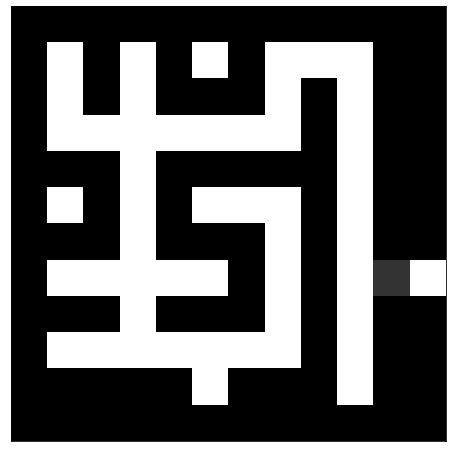

Epoch: 200 
 Step: 20 
 Position: (7, 10)

In [14]:
agent.learn(epochs=200, epsilon=0.2)

In [15]:
qtable3 = agent.qtable_to_pandas()

In [16]:
qtable3[(qtable3.up != 0) | (qtable3.down != 0) | (qtable3.right != 0) | (qtable3.left != 0)]

,up,down,right,left
state,,,,
13,0.000000,-7.170606,0.000000,0.000000
15,0.000000,-7.173508,0.000000,0.000000
19,0.000000,-5.351299,3.224522,0.000000
20,0.000000,0.000000,3.189770,-5.931205
21,0.000000,3.136452,0.000000,-4.726098
25,-4.390298,-4.833591,0.000000,0.000000
27,-3.290298,-3.686366,0.000000,0.000000
31,3.246910,-4.791897,0.000000,0.000000
33,-6.492336,3.056797,0.000000,0.000000


# Maze #4. Size 14x14
<img src="mazes/maze4.png">

In [17]:
agent = Agent("mazes/maze4.png", (32,32))

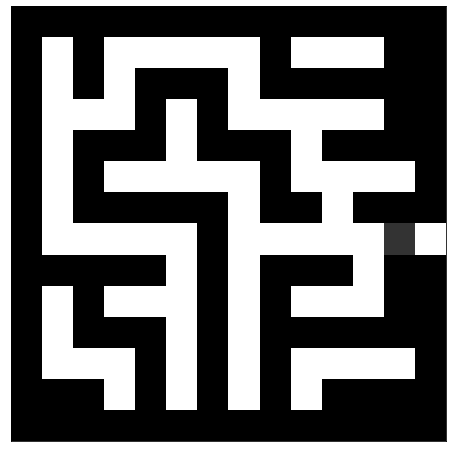

Epoch: 100 
 Step: 33 
 Position: (7, 12)

In [18]:
agent.learn(epochs=100, epsilon=0.2, steps_per_epoch=350)

In [19]:
qtable4 = agent.qtable_to_pandas()

In [20]:
qtable4[(qtable4.up != 0) | (qtable4.down != 0) | (qtable4.right != 0) | (qtable4.left != 0)]

,up,down,right,left
state,,,,
15,0.000000,-4.681457,0.000000,0.000000
17,0.000000,-5.068706,2.899875,0.000000
18,0.000000,0.000000,2.901599,-6.465803
19,0.000000,0.000000,2.917551,-3.705406
20,0.000000,0.000000,2.935184,-4.027908
21,0.000000,2.939265,0.000000,-4.795028
29,-2.343151,-1.278797,0.000000,0.000000
31,2.910284,-4.479167,0.000000,0.000000
35,-3.607832,2.926518,0.000000,0.000000


# Maze #5. Size 16x16
<img src="mazes/maze5.png">

In [21]:
agent = Agent("mazes/maze5.png", (32,32))

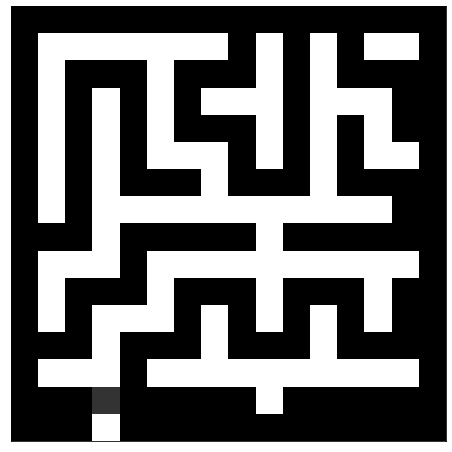

Epoch: 150 
 Step: 34 
 Position: (14, 3)

In [22]:
agent.learn(epochs=150, epsilon=0.2, steps_per_epoch=350)

In [23]:
qtable5 = agent.qtable_to_pandas()

In [24]:
qtable5[(qtable5.up != 0) | (qtable5.down != 0) | (qtable5.right != 0) | (qtable5.left != 0)]

,up,down,right,left
state,,,,
17,0.000000,-6.350819,3.186917,0.000000
18,0.000000,0.000000,3.183775,-6.784711
19,0.000000,0.000000,3.184920,-5.793903
20,0.000000,0.000000,3.190312,-4.927746
21,0.000000,3.197432,-1.632016,-5.648558
22,0.000000,0.000000,-5.783692,-4.710765
23,0.000000,0.000000,0.000000,-9.417096
27,0.000000,-8.648098,0.000000,0.000000
33,3.191713,-4.920867,0.000000,0.000000


# Save Q-Tables

In [26]:
qtable1

,up,down,right,left
state,,,,
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000


In [27]:
qtable1.to_csv("qtables/qtable1.csv", header=True, index=True)
qtable2.to_csv("qtables/qtable2.csv", header=True, index=True)
qtable3.to_csv("qtables/qtable3.csv", header=True, index=True)
qtable4.to_csv("qtables/qtable4.csv", header=True, index=True)
qtable5.to_csv("qtables/qtable5.csv", header=True, index=True)